<a href="https://colab.research.google.com/github/bksaini078/Security-ML/blob/main/MeanTeacher_security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# Plots

In [ ]:
from matplotlib import pyplot
def plot_roc(fpr,tpr,label):
    #  plot the roc curve for the model
    pyplot.plot(fpr, tpr, linestyle='--', label=label)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot 
    pyplot.show()
    return
def scatter_plot(logits, y_t, title):
    marker_size=20
    figure = plt.figure(figsize=(20, 6))
    plt.scatter(logits,logits, marker_size, c=y_t)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Predicted Probability")
    cbar= plt.colorbar()
    cbar.set_label("Probability", labelpad=+1)
    plt.show()
    return

#Reading data

In [ ]:
'''0-Normal, 1 is attack'''

path_train = "/content/drive/MyDrive/Security/UNSW_NB15/UNSW_NB15_training-set.csv"
path_test = "/content/drive/MyDrive/Security/UNSW_NB15/UNSW_NB15_training-set.csv"
df_train=pd.read_csv(path_train, header=0,dtype='unicode')
df_test=pd.read_csv(path_test, header=0,dtype='unicode')
x_train=df_train.sample(n=20000,random_state=42)
y_train=x_train['label'].astype(int)
x_train=x_train.drop(columns=['id','label'])

x_test=df_test.sample(n=20000,random_state=42)
y_test=x_test['label'].astype(int)
x_test=x_test.drop(columns=['id','label'])




In [ ]:
y_train=np.reshape(np.array(y_train),(len(y_train),1))
y_test=np.reshape(np.array(y_test),(len(y_test),1))
y_train = tf.keras.utils.to_categorical(y_train,2)
y_test = tf.keras.utils.to_categorical(y_test,2)


In [ ]:
#min max normalization 
from sklearn.preprocessing import MinMaxScaler
minmax_norm= MinMaxScaler()
minmax_norm.fit(x_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
x_train_norm= minmax_norm.transform(x_train)
x_train.shape

(20000, 42)

In [ ]:
x_test_norm=minmax_norm.transform(x_test)
x_test_norm.shape

(20000, 42)

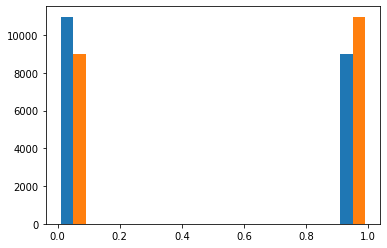

In [ ]:
'''0-Normal, 1 is attack'''
plt.hist(y_train)
plt.show()

# Cost Function

In [ ]:
# declaring loss function
import tensorflow as tf

# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
# Bhupender method names should be always lowerized, see: https://www.python.org/dev/peps/
def compute_clf_loss(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating
    the binary cross entropy .
    """

    # Change -1s to zeros to make cross-entropy computable
    # applicable = tf.not_equal(labels, -1)

    # labels = tf.where(applicable, labels, tf.zeros_like(labels))
    # logits = tf.where(applicable, logits, tf.zeros_like(logits))
    loss = tf.keras.losses.categorical_crossentropy(labels, logits,from_logits=True)

    # mask Nan values, makes them zero
    # loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)

    # compute the loss only from labeled samples
    # mask = tf.not_equal(loss, 0.)
    # masked = tf.boolean_mask(loss, mask)
    loss = tf.reduce_mean(loss)

    return loss

def compute_consistency_loss(student_output, teacher_output):
    return (tf.losses.mean_squared_error(student_output, teacher_output ))
def Overall_Cost( x_train, y_train,student, teacher,ratio):
    '''Calculating overall cost using classification cost and consistency cost'''
    # including noise data in train data


    # student prediction
    logit_student = student(x_train)

    # including different noise data in train data
    # x_train_n1, _ = augment_data(x_train, y_train, x_unlabel_tar, args)

    # calculating classification cost
    classification_cost = compute_clf_loss(logit_student, y_train)

    # teacher prediction
    logit_teacher = teacher(x_train)

    # calculating consistency cost
    consistency_cost = compute_consistency_loss(logit_student, logit_teacher)

    return (ratio * classification_cost) + ((1 - ratio) * consistency_cost)


# function for consistency cost
def EMA(student_model, teacher_model, alpha):
    # alpha = min(1 - 1 / (global_step + 1), alpha)
    # taking weights
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    # length must be equal otherwise it will not work
    assert len(student_weights) == len(
        teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))
    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha * (teacher_weights[i]) + (1 - alpha) * layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model


# supervised model

In [ ]:
#creating supervised model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
def supermodel():
    input= Input(shape=(42,))
    x= Dense(40)(input)
    x=Dense(30,activation='relu')(x)
    x=GaussianNoise(0.2)(x)
    x=Dense(16)(x)
    x=Dense(1,activation='sigmoid')(x)
    model= Model(input,x)
    model.compile(tf.keras.optimizers.Adam(learning_rate= 0.00001 ), loss= 'binary_crossentropy', metrics=['accuracy'])
    return model
def seqmodel():
    model= Sequential()
    model.add(Dense(42))
    model.add(GaussianNoise(0.2))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Dense(2,activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
  
    return model

In [ ]:
model=seqmodel()
# model.summary()

Epoch 1/200
63/63 [==============================] - 1s 11ms/step - loss: 0.7296 - accuracy: 0.4944 - val_loss: 0.6752 - val_accuracy: 0.5570
Epoch 2/200
63/63 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5849 - val_loss: 0.6413 - val_accuracy: 0.7697
Epoch 3/200
63/63 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6896 - val_loss: 0.6041 - val_accuracy: 0.7850
Epoch 4/200
63/63 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.7378 - val_loss: 0.5630 - val_accuracy: 0.7865
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.5781 - accuracy: 0.7455 - val_loss: 0.5214 - val_accuracy: 0.7812
Epoch 6/200
63/63 [==============================] - 0s 4ms/step - loss: 0.5384 - accuracy: 0.7591 - val_loss: 0.4838 - val_accuracy: 0.7868
Epoch 7/200
63/63 [==============================] - 0s 4ms/step - loss: 0.5051 - accuracy: 0.7639 - val_loss: 0.4520 - val_accuracy: 0.7950
Epoch 8/200


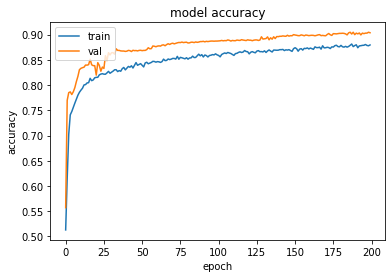

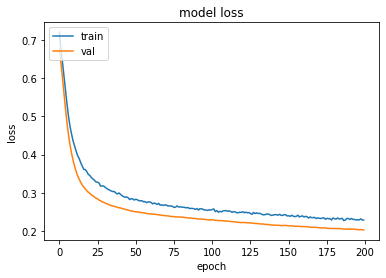

In [ ]:
history=model.fit(x_train_norm,y_train, batch_size=256,epochs=200,validation_split=0.2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
y_hat=model.predict(x_test_norm)
y_pred=tf.argmax(y_hat,1)
print(classification_report(tf.argmax(y_test,1),y_pred))
cm1=confusion_matrix(tf.argmax(y_test,1),y_pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
precision_score(tf.argmax(y_test,1),y_pred),recall_score(tf.argmax(y_test,1),y_pred),f1_score(tf.argmax(y_test,1),y_pred)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      9019
           1       0.95      0.86      0.91     10981

    accuracy                           0.90     20000
   macro avg       0.90      0.91      0.90     20000
weighted avg       0.91      0.90      0.90     20000

Sensitivity :  0.9499944561481317
Specificity :  0.861852290319643


(0.9545133635905194, 0.861852290319643, 0.9058192955589587)

# Mean teacher

In [ ]:
def MeanTeacher(x_train, y_train,x_test, y_test, batch_size,epochs,alpha) :
    # preparing the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices ( (x_train, y_train) )
    train_dataset = train_dataset.shuffle ( buffer_size=1024 ).batch ( batch_size )
    
    # declaring optimiser
    optimizer = tf.keras.optimizers.Adam (learning_rate=0.0001 )  # trying changing learning rate , sometimes it gives good result
    student = seqmodel()
    teacher = seqmodel()
    train_metrics = tf.keras.metrics.BinaryAccuracy ( name='Binary_Accuracy' )
    val_metrics = tf.keras.metrics.BinaryAccuracy ( name='val_Accuracy' )
    progbar = tf.keras.utils.Progbar ( len ( x_train ), stateful_metrics=['Accuracy', 'Loss','val_acc'] )
    for epoch in range ( 1, epochs + 1 ) :
        tf.print ( '\nepoch %d' % (epoch,) )
        for step, (x_batch_train,  y_batch_train) in enumerate ( train_dataset ) :
            with tf.GradientTape () as tape :
                overall_cost = Overall_Cost ( x_batch_train, y_batch_train, 
                                              student, teacher,0.5 )
            grads = tape.gradient ( overall_cost, student.trainable_weights )
            optimizer.apply_gradients (
                (grad, var) for (grad, var) in zip ( grads, student.trainable_weights ) if grad is not None )
            teacher = EMA ( student, teacher, alpha=alpha )
            logits_t = teacher( x_train[:200] )
            
            train_acc = train_metrics ( tf.argmax(y_train[:200],1),tf.argmax(logits_t,1)  )
            progbar.add ( batch_size, values=[('Accuracy', train_acc), ('Loss', overall_cost)] )

            y_p = teacher(x_test_norm[:200])
            val_acc = val_metrics(tf.argmax(y_test[:200],1), tf.argmax(y_p,1))
            progbar.update(step,values=[('val_acc',val_acc)])
    

    tf.keras.backend.clear_session ()
    return student, teacher

In [ ]:
student,teacher=MeanTeacher(x_train_norm,y_train,x_test_norm,y_test,128,200,0.99)

In [ ]:
y_hat=student.predict(x_test_norm)
y_pred=tf.argmax(y_hat,1)

cm1=confusion_matrix(tf.argmax(y_test,1),y_pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
precision_score(tf.argmax(y_test,1),y_pred),recall_score(tf.argmax(y_test,1),y_pred),f1_score(tf.argmax(y_test,1),y_pred)

Sensitivity :  0.9587537421000111
Specificity :  0.9495492213823877


(0.9655523659598111, 0.9495492213823877, 0.9574839302112029)

In [ ]:
y_hat=teacher.predict(x_test_norm)
y_pred=tf.argmax(y_hat,1)

cm1=confusion_matrix(tf.argmax(y_test,1),y_pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
precision_score(tf.argmax(y_test,1),y_pred),recall_score(tf.argmax(y_test,1),y_pred),f1_score(tf.argmax(y_test,1),y_pred)

Sensitivity :  0.9454484976161437
Specificity :  0.9589290592842182


(0.9553620032661949, 0.9589290592842182, 0.9571422078807436)